In [37]:
%reset
import subprocess, psutil, time, json, pandas, math, numpy, threading
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter


## OLD: Memory Consumption Plots

#### Setup

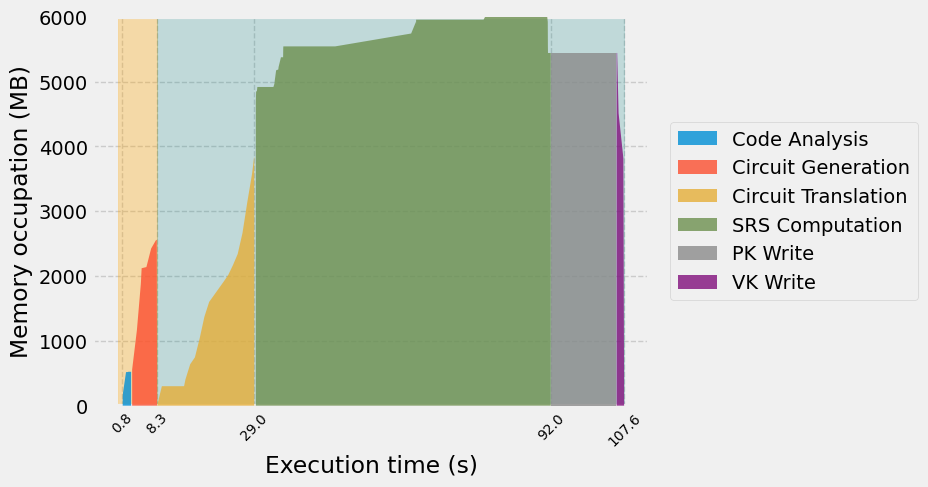

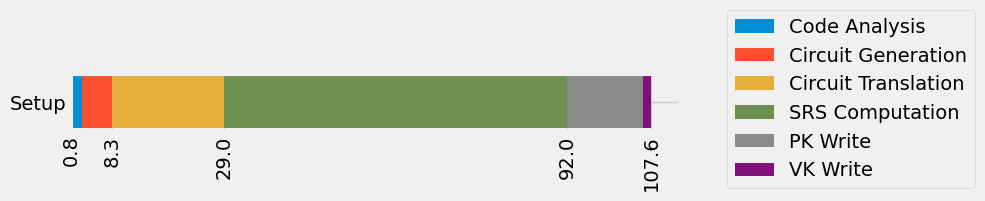

([<matplotlib.axis.XTick at 0x2bfa7f86710>,
 [Text(0.818, 0, '0.8'),
  Text(107.594, 0, '107.6'),
  Text(8.318, 0, '8.3'),
  Text(28.979, 0, '29.0'),
  Text(92.004, 0, '92.0')])

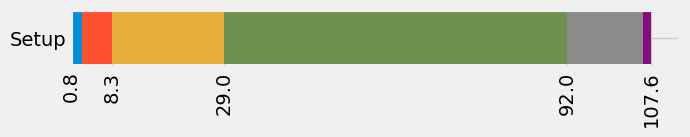

In [27]:
circuit = 'HTTP_String'
#pastel_cmap = cm.get_cmap('Pastel1')
df_temp = pandas.read_json("outputs/all/setup_"+circuit+"_output.json").round(3)
df_temp.columns = ['output', 'timestamp']
#print(df.to_string())
timestamps=df_temp['timestamp']
df_temp = df_temp.iloc[:, [1,0]]
df_temp.set_index('timestamp')

df = pandas.read_json("outputs/all/setup_"+circuit+"_memory.json").round(3)
df.columns = ['memory', 'timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')
#df_temp['timestamp'].add(last_time)
#df=df.append(df_temp,ignore_index=True)
#print(df.to_string())
#print(df.to_string())
#print(df_temp.to_string())
timestamps=df_temp['timestamp']

highlights = [timestamps[0], timestamps[96], timestamps[108], timestamps[118], timestamps[191], timestamps[192], timestamps[199]]
#print(df['timestamp'])

labels = ["Code Analysis", "Circuit Generation", "Circuit Translation", "SRS Computation", "PK Write", "VK Write"]
df.set_index('timestamp') 
df_temp.set_index('timestamp')
df = df.merge(df_temp, how = 'outer')
df['memory'] = df['memory'].fillna(value=0)
df['timestamp'] = df['timestamp']-df['timestamp'].iloc[0]
#print(df.to_string())


fig, ax = plt.subplots()
ax.set_ylim(0, 100)
#print(plt.style.available)
#plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=0, zorder=3)
#plt.title("HTTP_String: Memory occupation over time")
#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[highlights[0], highlights[-1]]
thr = 3
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)
plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
#plt.xticks(numpy.arange(0, max(df['timestamp']), step=max(df['timestamp'])/5))
plt.xticks(ticks, rotation = 45, fontsize=10)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 1, zorder=2)
plt.axvspan(0, highlights[2], color='orange', alpha=0.3, zorder=1)
plt.axvspan(highlights[2], highlights[-1], color='teal', alpha=0.2, zorder=1)
#plt.axvline(highlights[3])

plt.show()
plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.3))
plt.xticks(ticks, rotation=90)
#plt.ylim(0,0.2)
plt.show()
plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.3))
plt.xticks(ticks, rotation=90)


##END SETUP###


### Prove

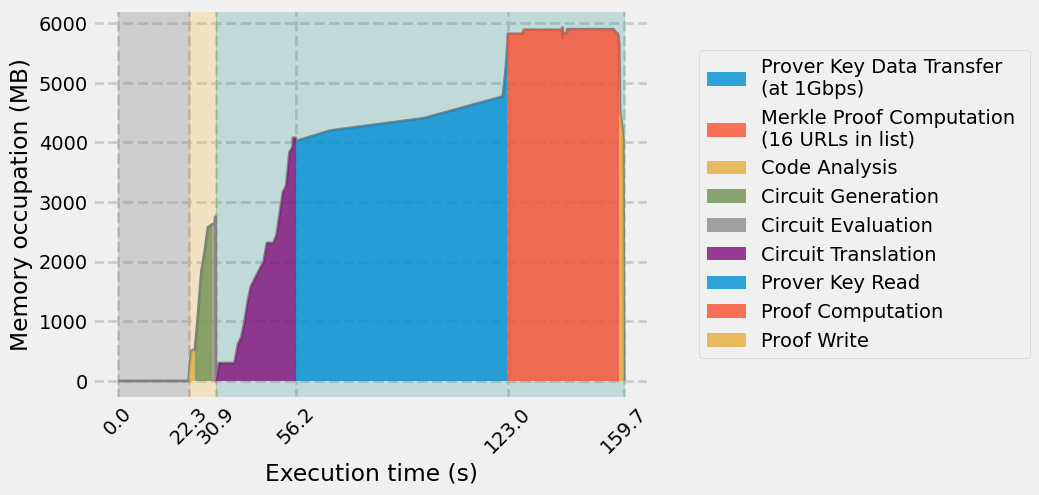

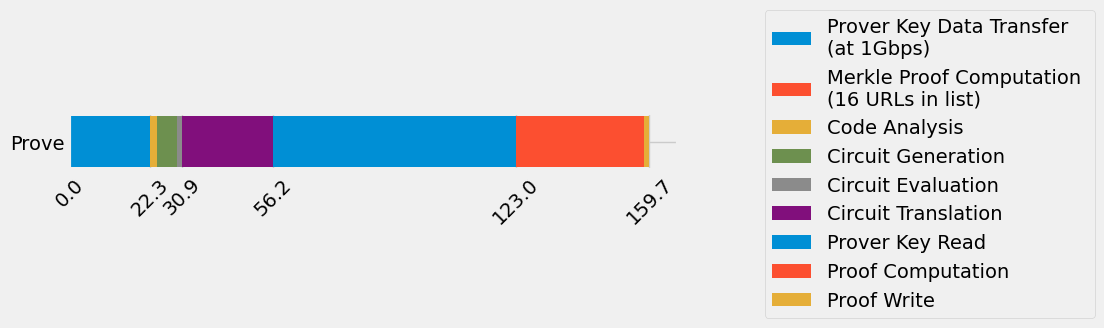

In [28]:
max_memory = []
exec_time = []
circuit = 'HTTP_String'

###PROVE###
###SETUP PLOT###
df2 = pandas.read_json("outputs/all/prove_"+circuit+"_output.json").round(5)
df2.columns = ['output', 'timestamp']
timestamps=df2['timestamp']
df2 = df2.iloc[:, [1,0]]
df2.set_index('timestamp')
#print(df2.to_string())
#print("___________________________________________________________")

df = pandas.read_json("outputs/all/prove_"+circuit+"_memory.json").round(5)
df.columns = ['memory', 'timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')
#print(df.to_string())
#print(df.to_string())
#print(df2.to_string())
#print(df[:300].to_string())
df = df.merge(df2, how = 'outer')
df = df.sort_values('timestamp').reset_index(drop=True)
df['memory'] = df['memory'].fillna(value=0)
max_memory = [max(df['memory'])]
exec_time = [df['timestamp'].tail(1).values[0]]


timestamps=df['timestamp']
highlights = [timestamps[0], timestamps[1], timestamps[3], timestamps[102], timestamps[114], timestamps[351], timestamps[385], timestamps[451], timestamps[546], timestamps[549]]
labels = ["Prover Key Data Transfer \n(at 1Gbps)", "Merkle Proof Computation \n(16 URLs in list)", "Code Analysis", "Circuit Generation", "Circuit Evaluation", "Circuit Translation", "Prover Key Read", "Proof Computation", "Proof Write"]

plt.figure()

#print(plt.style.available)
plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[highlights[0], highlights[-1], highlights[5]]
thr = 3
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)

plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
plt.xticks(ticks, rotation = 45)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 2, zorder=20)
plt.axvspan(0, highlights[2], alpha=0.3, color='grey', zorder=1)
plt.axvspan(highlights[2], highlights[5], alpha=0.2, color='orange', zorder=1)
plt.axvspan(highlights[5], highlights[-1], alpha=0.2, color='teal', zorder=1)

#plt.axvline(highlights[2], linewidth=1)
#plt.axvline(highlights[5], linewidth=1)

plt.show()

plt.figure(figsize=(7, 0.7))

for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Prove", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 3))
plt.xticks(ticks, rotation=45)
#plt.ylim(0,1)
plt.show()

### Verify

     timestamp    memory                                                                                                                                                               output
0        0.000     0.000                                                                                                                                                       Proof received
1        0.000     0.000                                                                                                                                              Verification starts now
2        0.003     0.221                                                                                                                                                                  NaN
3        0.023     0.000                                                                                                   [1st Phase] Running Initial Circuit Analysis for < HTTP_String >\n
4        0.026    34.050                          

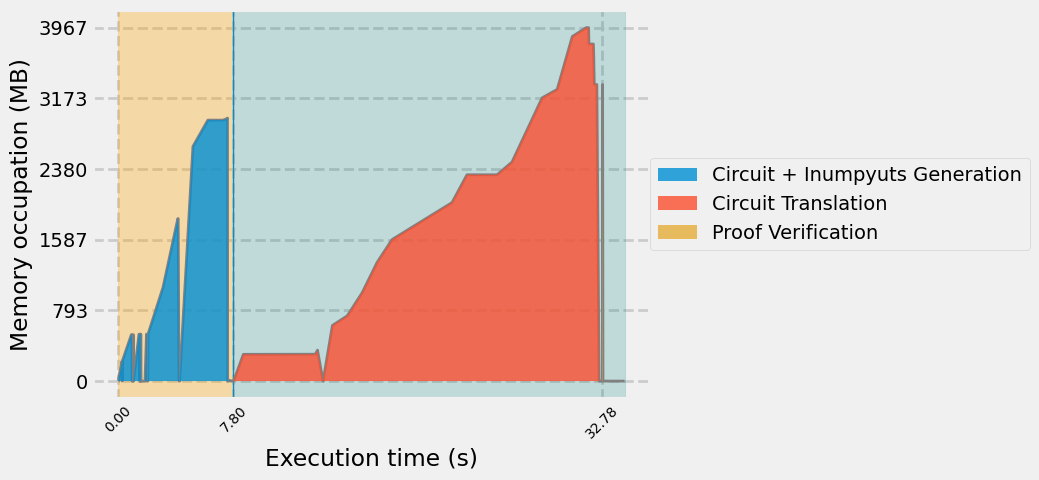

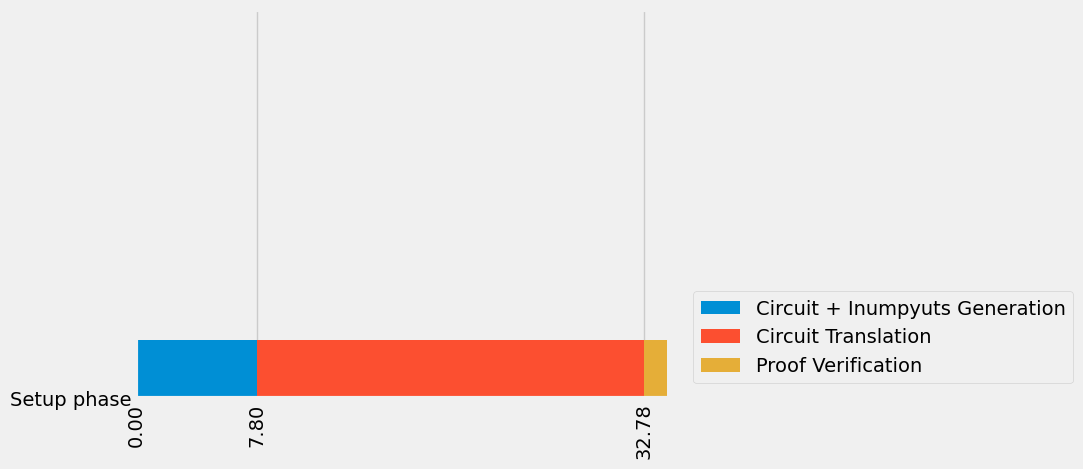

In [4]:
circuit = "HTTP_String"
df2 = pandas.read_json("outputs/all/verify_"+circuit+"_output.json").round(3)
df2.columns = ['output', 'timestamp']
timestamps=df2['timestamp']
df2 = df2.iloc[:, [1,0]]
df2.set_index('timestamp')
#print(df2.to_string())
#print("___________________________________________________________")
timestamps=df2['timestamp']

highlights = [timestamps[0], timestamps[110], timestamps[125], timestamps[153]]#, timestamps[114], timestamps[351], timestamps[385], timestamps[451], timestamps[546], timestamps[549]]
df = pandas.read_json("outputs/all/verify_"+circuit+"_memory.json").round(3)
df.columns = ['memory', 'timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')
#print(df.to_string())
#print(df.to_string())
#print(df2.to_string())
#print(df[:300].to_string())
df = df.merge(df2, how = 'outer')
df = df.sort_values('timestamp').reset_index(drop=True)
df['memory'] = df['memory'].fillna(value=0)
print(df.to_string())

print(highlights)
labels = ["Circuit + Inumpyuts Generation", "Circuit Translation", "Proof Verification"]

plt.figure()

#print(plt.style.available)
plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[]
for tick in highlights:
	if not ticks or ticks[-1]<tick-3:
		ticks.append(tick)
plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.append(numpy.arange(0, max(df['memory']), step=max(df['memory'])/5), max(df['memory'])))
#plt.xticks(numpy.arange(0, max(df['timestamp']), step=max(df['timestamp'])/5))
plt.xticks(ticks, rotation = 45, fontsize=10)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 2, zorder=20)
plt.axvspan(0, highlights[1], alpha=0.3, color='orange', zorder=1)
plt.axvspan(highlights[1], highlights[-1], alpha=0.2, color='teal', zorder=1)

plt.axvline(highlights[1], linewidth=1)
#plt.axvline(highlights[], linewidth=1)


plt.show()

for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup phase", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.3))
plt.xticks(ticks, rotation=90)
plt.ylim(0,1)
plt.show()

# New Plots: Memory / Time

In [38]:
circuit = 'HTTP_String'
run = 1
path = "outputs/full_simulations/"+circuit+"/run"+str(run)
print(path)

outputs/full_simulations/HTTP_String/run1


### Setup

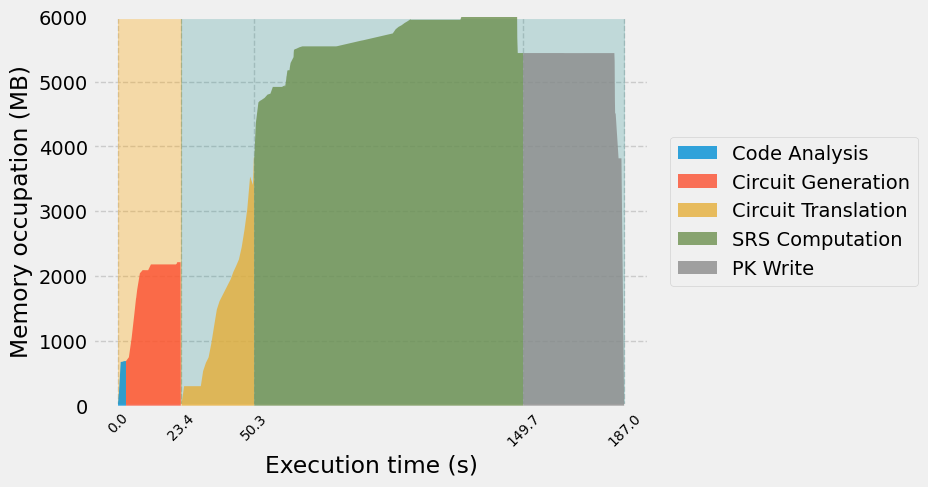

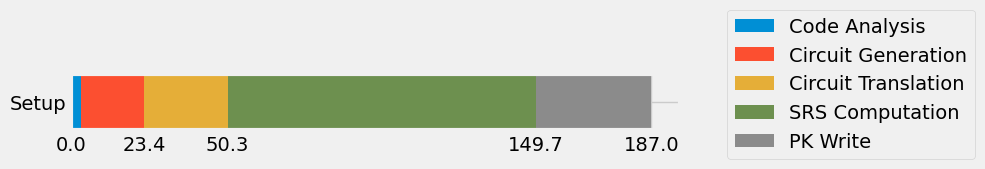

([<matplotlib.axis.XTick at 0x2bfa51223e0>,
 [Text(0.02, 0, '0.0'),
  Text(187.03, 0, '187.0'),
  Text(23.43, 0, '23.4'),
  Text(50.33, 0, '50.3'),
  Text(149.71, 0, '149.7')])

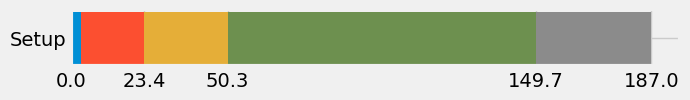

In [39]:
circuit = 'HTTP_String'
#pastel_cmap = cm.get_cmap('Pastel1')
df_temp = pandas.read_json(path+"/setup_"+circuit+"_output.json").round(2)
df_temp.columns = ['output', 'timestamp', 'cpu_timestamp']
#print(df.to_string())
timestamps=df_temp['timestamp']
df_temp = df_temp.iloc[:, [1,2,0]]
df_temp.set_index('timestamp')
#print(df_temp.to_string())


df = pandas.read_json(path+"/setup_"+circuit+"_memory.json").round(2)
df.columns = ['memory', 'timestamp', 'cpu_timestamp']
df = df.iloc[:, [1,2,0]]
df.set_index('timestamp')
#df_temp['timestamp'].add(last_time)
#df=df.append(df_temp,ignore_index=True)
#print(df.to_string())
#print(df.to_string())
#print(df_temp.to_string())
timestamps=df_temp['timestamp']


highlights = [timestamps[df_temp['output'].str.contains('\[1st Phase\]')].values[0], 
	      	timestamps[df_temp['output'].str.contains('\[2nd Phase\]')].values[0], 
			timestamps[df_temp['output'].str.contains('Reset time counters for profiling')].values[0],
			timestamps[df_temp['output'].str.contains('Example created!')].values[0],
			timestamps[df_temp['output'].str.contains('Writing prover key to file...')].values[0], 
			timestamps.tail(1).values[0]]
#highlights = [timestamps[0], timestamps[96], timestamps[327], timestamps[336], timestamps[409], timestamps[410], timestamps[417]]
#print(df['timestamp'])

labels = ["Code Analysis", "Circuit Generation", "Circuit Translation", "SRS Computation", "PK Write", "VK Write"]
df.set_index('timestamp') 
df_temp.set_index('timestamp')
df = df.merge(df_temp, how = 'outer')
df['memory'] = df['memory'].fillna(value=0)
df['timestamp'] = df['timestamp']-df['timestamp'].iloc[0]



#print(df.to_string())


fig, ax = plt.subplots()
ax.set_ylim(0, 100)
#print(plt.style.available)
#plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=0, zorder=3)

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[highlights[0], highlights[-1]]
thr = 7
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)
plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
#plt.xticks(numpy.arange(0, max(df['timestamp']), step=max(df['timestamp'])/5))
plt.xticks(ticks, rotation = 45, fontsize=10)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 1, zorder=2)
plt.axvspan(0, highlights[2], color='orange', alpha=0.3, zorder=1)
plt.axvspan(highlights[2], highlights[-1], color='teal', alpha=0.2, zorder=1)
#plt.axvline(highlights[3])

plt.show()
plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.3))
plt.xticks(ticks, rotation=0)
#plt.ylim(0,0.2)
plt.show()
plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.3))
plt.xticks(ticks, rotation=0)


##END SETUP###


### Prove

252.08464
[0.0, 31.61077, 31.61084, 38.88876, 56.89263, 59.02492, 93.3487, 199.69343, 248.3214, 252.08464]


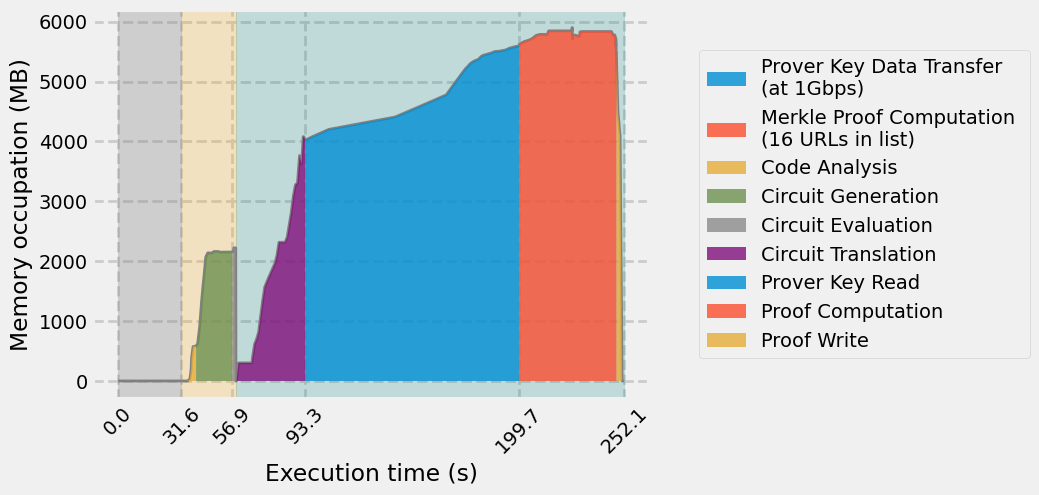

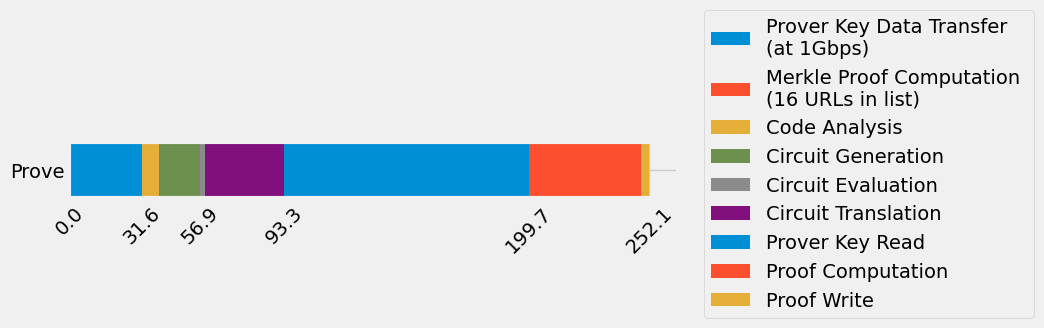

([<matplotlib.axis.XTick at 0x2bfa800c0d0>,
 [Text(0.0, 0, '0.0'),
  Text(252.08464, 0, '252.1'),
  Text(56.89263, 0, '56.9'),
  Text(31.61077, 0, '31.6'),
  Text(93.3487, 0, '93.3'),
  Text(199.69343, 0, '199.7')])

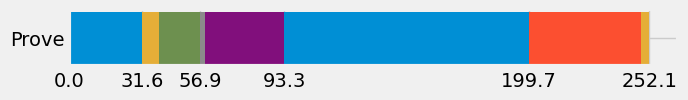

In [40]:
max_memory = []
exec_time = []

###PROVE###
###SETUP PLOT###
df2 = pandas.read_json(path+"/prove_"+circuit+"_output.json").round(5)
df2.columns = ['output', 'timestamp', 'cpu_timestamp']
timestamps=df2['timestamp']
df2 = df2.iloc[:, [1,0, 2]]
df2.set_index('timestamp')
#print(df2.to_string())
#print("___________________________________________________________")

df = pandas.read_json(path+"/prove_"+circuit+"_memory.json").round(5)
df.columns = ['memory', 'timestamp', 'cpu_timestamp']
df = df.iloc[:, [1,0, 2]]
df.set_index('timestamp')
#print(df.to_string())
#print(df.to_string())
#print(df2.to_string())
#print(df[:300].to_string())
df = df.merge(df2, how = 'outer')
df = df.sort_values('timestamp').reset_index(drop=True)
df['memory'] = df['memory'].fillna(value=0)
max_memory = [max(df['memory'])]
exec_time = [df['timestamp'].tail(1).values[0]]


timestamps=df2['timestamp']
print(timestamps.tail(1).values[0])
highlights = [timestamps[df2['output'].str.contains('Request sent')].values[0], 
	      	timestamps[df2['output'].str.contains('Key received')].values[0], 
			timestamps[df2['output'].str.contains('Merkle computations done')].values[0],
			timestamps[df2['output'].str.contains('\[2nd Phase\]')].values[0],
			timestamps[df2['output'].str.contains('Evaluating Input on the circuit')].values[0], 
			timestamps[df2['output'].str.contains('Reset time counters for profiling')].values[0], 
			timestamps[df2['output'].str.contains('Reading key...')].values[0], 
			timestamps[df2['output'].str.contains('Generating proof...')].values[0], 
			timestamps[df2['output'].str.contains('Writing proof to file...')].values[0],
			timestamps.tail(1).values[0]]
#highlights = [timestamps[0], timestamps[1], timestamps[2], timestamps[100], timestamps[114], timestamps[341], timestamps[350], timestamps[351], timestamps[411], timestamps[413]]
labels = ["Prover Key Data Transfer \n(at 1Gbps)", "Merkle Proof Computation \n(16 URLs in list)", "Code Analysis", "Circuit Generation", "Circuit Evaluation", "Circuit Translation", "Prover Key Read", "Proof Computation", "Proof Write"]
print(highlights)
plt.figure()

#print(plt.style.available)
#plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[highlights[0], highlights[-1], highlights[4]]
thr = 8
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)

plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
plt.xticks(ticks, rotation = 45)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 2, zorder=20)
plt.axvspan(0, highlights[2], alpha=0.3, color='grey', zorder=1)
plt.axvspan(highlights[2], highlights[5], alpha=0.2, color='orange', zorder=1)
plt.axvspan(highlights[5], highlights[-1], alpha=0.2, color='teal', zorder=1)

#plt.axvline(highlights[2], linewidth=1)
#plt.axvline(highlights[5], linewidth=1)

plt.show()

plt.figure(figsize=(7, 0.7))

for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Prove", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 3.5))
plt.xticks(ticks, rotation=45, zorder = 100)
#plt.ylim(0,1)
plt.show()

plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Prove", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.xticks(ticks, rotation=0)
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.3))


### Verify

1.309
[0.0, 1.309, 4.537, 23.834, 54.888, 57.823]


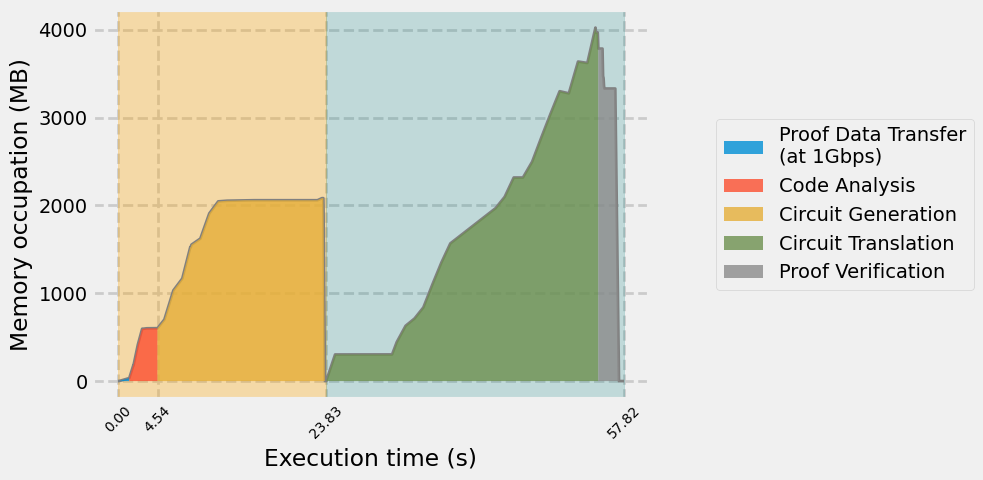

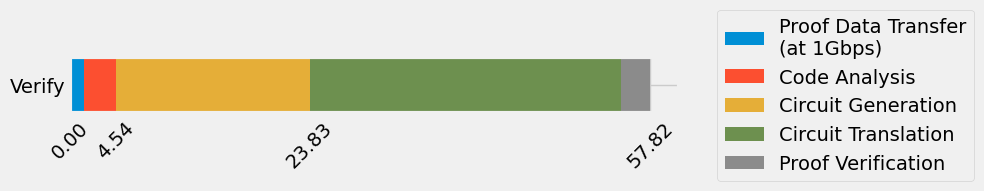

([<matplotlib.axis.XTick at 0x2bfa7f607f0>,
 [Text(0.0, 0, '0.00'),
  Text(57.823, 0, '57.82'),
  Text(4.537, 0, '4.54'),
  Text(23.834, 0, '23.83')])

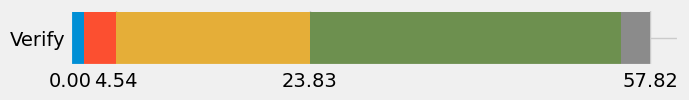

In [42]:
circuit = "HTTP_String"
df2 = pandas.read_json(path+"/verify_"+circuit+"_output.json").round(3)
df2.columns = ['output', 'timestamp', 'cpu_timestamp']
timestamps=df2['timestamp']
df2 = df2.iloc[:, [1,0,2]]
df2.set_index('timestamp')
#print(df2.to_string())

print(timestamps[df2['output'].str.contains('\[1st Phase\]')].values[0])
#print("___________________________________________________________")
timestamps=df2['timestamp']
highlights = [timestamps[df2['output'].str.contains('Verification starts now')].values[0], 
              timestamps[df2['output'].str.contains('\[1st Phase\]')].values[0], 
              timestamps[df2['output'].str.contains('\[2nd Phase\]')].values[0], 
              timestamps[df2['output'].str.contains('Reset time counters for profiling\n')].values[0], 
              timestamps[df2['output'].str.contains('Reading verification key \(preprocessed\)')].values[0], 
              timestamps.tail(1).values[0]]
print(highlights)
#highlights = [timestamps[0], timestamps[110], timestamps[125], timestamps[153]]#, timestamps[114], timestamps[351], timestamps[385], timestamps[451], timestamps[546], timestamps[549]]
#print(highlights)
df = pandas.read_json(path+"/verify_"+circuit+"_memory.json").round(3)
df.columns = ['memory', 'timestamp', 'cpu_timestamp']
df = df.iloc[:, [1,0,2]]
df.set_index('timestamp')
#print(df.to_string())
#print(df.to_string())
#print(df2.to_string())
#print(df[:300].to_string())
df = df.merge(df2, how = 'outer')
df = df.sort_values('timestamp').reset_index(drop=True)
df['memory'] = df['memory'].fillna(value=0)
#print(df.to_string())

#print(highlights)
labels = ["Proof Data Transfer\n(at 1Gbps)", "Code Analysis", "Circuit Generation", "Circuit Translation", "Proof Verification"]

plt.figure()

#print(plt.style.available)
#plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[highlights[0], highlights[-1]]
thr = 3
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)

plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 5000, step=1000))
#plt.xticks(numpy.arange(0, max(df['timestamp']), step=max(df['timestamp'])/5))
plt.xticks(ticks, rotation = 45, fontsize=10)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 2, zorder=20)
plt.axvspan(0, highlights[3], alpha=0.3, color='orange', zorder=1)
plt.axvspan(highlights[3], highlights[-1], alpha=0.2, color='teal', zorder=1)

#plt.axvline(highlights[3], linewidth=1)
#plt.axvline(highlights[], linewidth=1)


plt.show()

plt.figure(figsize=(7, 0.7))

for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Verify", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2))
plt.xticks(ticks, rotation=45, zorder = 100)
#plt.ylim(0,1)
plt.show()

plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Verify", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.xticks(ticks, rotation=0)
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.3))

# Time / Space over Policy Length - HTTP_String

##### Subplots functions

In [84]:
def build_average(proc, circuit, path, url_range, run_range):
    times = pandas.DataFrame(url_range, columns = ['parameter'])
    for run in run_range:
        #print(run)
        run=str(run)
        new_times = []
        #num_gates=[]
        for i in url_range:   
            df = pandas.read_json(path+"run"+run+"/output_"+proc+"_"+circuit+"_"+str(i)+"_"+run+".json").round(5)
            if proc == 'libsnark_setup':
                df = df[:-2]
            df.columns = ['output', 'timestamp', 'cpu_timestamp']
            #num_gates += [df['output'][df['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1]]
            new_times += [df['timestamp'].tail(1).values[0]]
        times[run] = new_times
    #print(times.iloc[:,1:])
    times['avg'] = times.iloc[:,1:].mean(axis=1)
    return(times)


In [91]:

def four_plots(circuit, path, url_range, run_range):
    fig_times, axs_time = plt.subplots(2, 2, figsize=(10, 10))
    plt.style.use('default')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
    fig_times.suptitle("Time Complexity", fontsize=20)

    #fig_times = plt.figure()
    ytitle_times = "Execution Time (s)"
    xtitle = "Policy Size (bytes)"
    #print(times)
    times = build_average("java", circuit, path, url_range, run_range)
    axs_time[0][0].plot(times['parameter'], times['avg'],linestyle='--', marker='o', linewidth=1, markersize=10)
    axs_time[0][0].set_title('Circuit Generation', fontsize = 14)
    #axs_time[0][0].set_ylim([0, max(times['avg'])])

    #plt.show()

    times = build_average("libsnark_setup", circuit, path, url_range, run_range)
    axs_time[0][1].plot(times['parameter'], times['avg'],linestyle='--', marker='o', linewidth=1, markersize=10)
    axs_time[0][1].set_title('Setup Phase', fontsize = 14)
    #plt.show()

    times = build_average("libsnark_prove", circuit, path, url_range, run_range)
    axs_time[1][0].plot(times['parameter'], times['avg'],linestyle='--', marker='o', linewidth=1, markersize=10)
    axs_time[1][0].set_title('Proof Generation', fontsize = 14)

    plt.setp(axs_time, ylim=(0, max(times['avg'])+(max(times['avg'])/20)), xlim=(0, max(url_range)+min(url_range)*2), xticks=[i for i in range(0, max(url_range)+min(url_range), min(url_range)*2)])
    #plt.show()

    times = build_average("libsnark_verify", circuit, path, url_range, run_range)
    axs_time[1][1].plot(times['parameter'], times['avg'],linestyle='--', marker='o', linewidth=1, markersize=10)
    axs_time[1][1].set_title('Proof Verification', fontsize = 14)
    #plt.show()
    for ax in axs_time.flat:
        ax.grid(True, linestyle = '--', linewidth = 1, alpha=0.5)
        #ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlabel(xtitle, fontsize=10)
        ax.set_ylabel(ytitle_times, fontsize=10)
        ax.spines[:].set_visible(True)
        



In [ ]:
def build_prediction_list(proc, circuit, path, url_range, run_range):
    times = pandas.DataFrame(url_range, columns = ['parameter'])
    for run in run_range:
        #print(run)
        run=str(run)
        new_times = []
        #num_gates=[]
        for i in url_range:   
            df = pandas.read_json(path+"run"+run+"/output_"+proc+"_"+circuit+"_"+str(i)+"_"+run+".json").round(5)
            if proc == 'libsnark_setup':
                df = df[:-2]
            df.columns = ['output', 'timestamp', 'cpu_timestamp']
            #num_gates += [df['output'][df['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1]]
            new_times += [df['timestamp'].tail(1).values[0]]
        times[run] = new_times
    #print(times.iloc[:,1:])
    times['avg'] = times.iloc[:,1:].mean(axis=1)
    return(times)


In [175]:
from sklearn.linear_model import LinearRegression

def four_plots_with_prediction(circuit, path, url_range, run_range):
    fig_times, axs_time = plt.subplots(2, 2, figsize=(10, 10))
    plt.style.use('default')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
    fig_times.suptitle("Time Complexity", fontsize=20)

    #fig_times = plt.figure()
    ytitle_times = "Execution Time (s)"
    xtitle = "Policy Size (bytes)"
    #print(times)
    times = build_average("java", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time[0][0].plot(times['parameter'], times[str(i)],linestyle='--', marker='o', linewidth=1, markersize=5, label='Samples' if i == 7 else None, zorder=100)
        axs_time[0][0].set_title('Circuit Generation', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 5000, 5)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time[0][0].plot(url_range_pred, predictions, color='powderblue', label='Prediction', zorder=70)

    times = build_average("libsnark_setup", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time[0][1].plot(times['parameter'], times[str(i)],linestyle='--', marker='o', linewidth=1, markersize=5, label='Samples' if i == 7 else None, zorder=100)
        axs_time[0][1].set_title('Setup Phase', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 5000, 5)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time[0][1].plot(url_range_pred, predictions, color='powderblue', label='Prediction', zorder=70)

    times = build_average("libsnark_prove", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time[1][0].plot(times['parameter'], times[str(i)],linestyle='--', marker='o', linewidth=1, markersize=5, label='Samples' if i == 7 else None, zorder=100)
        axs_time[1][0].set_title('Proof Generation', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    plt.setp(axs_time, ylim=(0, max(times['avg'])+(max(times['avg'])/20)), xlim=(0, max(url_range)+min(url_range)*2), xticks=[i for i in range(0, max(url_range)+min(url_range), min(url_range)*2)])
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 5000, 5)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time[1][0].plot(url_range_pred, predictions, color='powderblue', label='Prediction', zorder=70)

    times = build_average("libsnark_verify", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time[1][1].plot(times['parameter'], times[str(i)],linestyle='--', marker='o', linewidth=1, markersize=5, label='Samples' if i == 7 else None, zorder=100)
        axs_time[1][1].set_title('Proof Verification', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 5000, 5)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time[1][1].plot(url_range_pred, predictions, color='powderblue', label='Prediction', zorder=70)

    for ax in axs_time.flat:
        ax.grid(True, linestyle = '--', linewidth = 1, alpha=0.5)
        #ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlabel(xtitle, fontsize=10)
        ax.set_ylabel(ytitle_times, fontsize=10)
        ax.spines[:].set_visible(True)
        ax.legend()

'''

    #print(X)

    #plt.show()

    times = build_average("libsnark_setup", circuit, path, url_range, run_range)
    for i in run_range:
        axs_time[0][1].plot(times['parameter'], times[str(i)],linestyle='--', marker='o', linewidth=1, markersize=5)
        axs_time[0][1].set_title('Setup Phase', fontsize = 14)

    #plt.show()
    #-------------------
    X = numpy.array(url_range).reshape(-1, 1)
    y=times['avg']
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model.coef_[0], model.intercept_)
    url_range_pred = [i for i in range(0, 5000, 5)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)

    #axs_time[0][1].scatter(url_range, y, label='Data Samples', s=100, zorder=100)
    axs_time[0][1].plot(url_range_pred, predictions, color='paleturquoise', label='Prediction')

    #plt.xlabel('X')
    #plt.ylabel('y')
    #plt.title('Prediction: Gates Number Growth Trend')
    
    #plt.grid(True)

    #plt.show()

    #---------------------
    times = build_average("libsnark_prove", circuit, path, url_range, run_range)
    for i in run_range:
        axs_time[1][0].plot(times['parameter'], times[str(i)],linestyle='--', marker='o', linewidth=1, markersize=5)
        axs_time[1][0].set_title('Proof Generation', fontsize = 14)


    times = build_average("libsnark_verify", circuit, path, url_range, run_range)
    for i in run_range:
        axs_time[1][1].plot(times['parameter'], times[str(i)],linestyle='--', marker='o', linewidth=1, markersize=5)
        axs_time[1][1].set_title('Proof Verification', fontsize = 14)


'''



'\n\n    #print(X)\n\n    #plt.show()\n\n    times = build_average("libsnark_setup", circuit, path, url_range, run_range)\n    for i in run_range:\n        axs_time[0][1].plot(times[\'parameter\'], times[str(i)],linestyle=\'--\', marker=\'o\', linewidth=1, markersize=5)\n        axs_time[0][1].set_title(\'Setup Phase\', fontsize = 14)\n\n    #plt.show()\n    #-------------------\n    X = numpy.array(url_range).reshape(-1, 1)\n    y=times[\'avg\']\n    model_time = LinearRegression()\n    model_time.fit(X, y)\n    print(model.coef_[0], model.intercept_)\n    url_range_pred = [i for i in range(0, 5000, 5)]\n    X_new = numpy.array(url_range_pred).reshape(-1, 1)\n    predictions = model_time.predict(X_new)\n\n    #axs_time[0][1].scatter(url_range, y, label=\'Data Samples\', s=100, zorder=100)\n    axs_time[0][1].plot(url_range_pred, predictions, color=\'paleturquoise\', label=\'Prediction\')\n\n    #plt.xlabel(\'X\')\n    #plt.ylabel(\'y\')\n    #plt.title(\'Prediction: Gates Number Growt

### HTTP_String

0.010681921597633131 4.746896230769236
0.05046664687573962 74.48146761538464
0.06272926005917157 93.93255423076928
0.01981350210650886 16.42884861538463


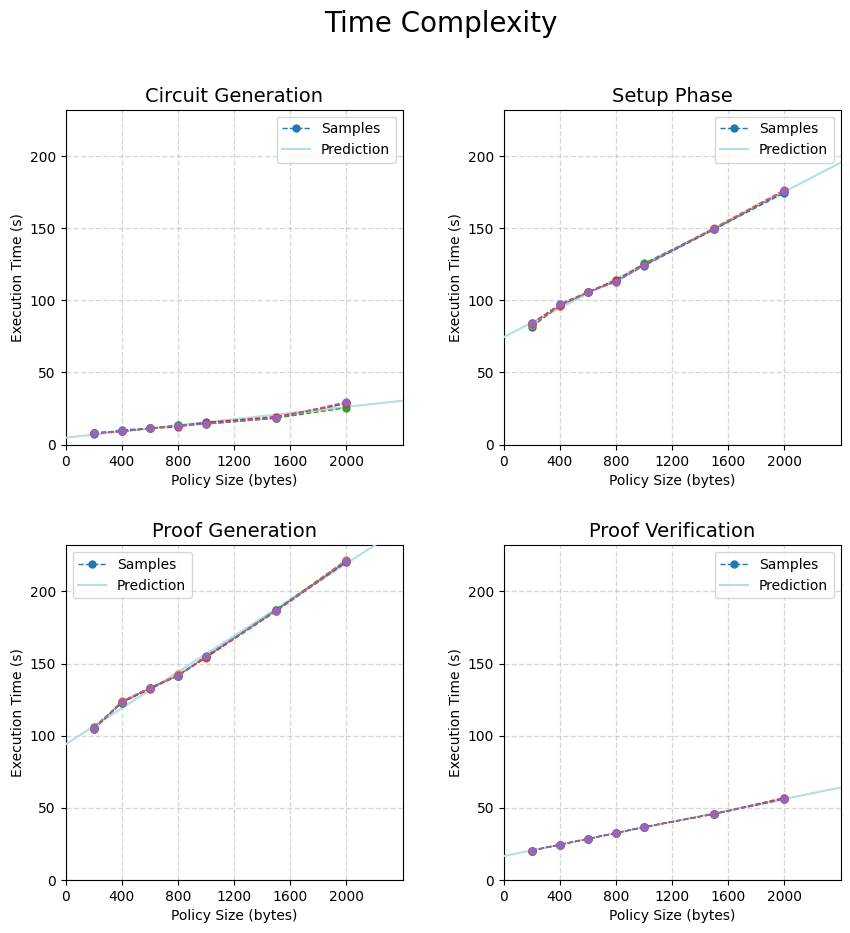

In [176]:
pk_size = []
circuit='HTTP_String'
url_range = [200, 400, 600, 800, 1000, 1500, 2000]
path = "outputs/Test_HTTP_String/"
#four_plots(circuit, path, url_range, range(7,12))
four_plots_with_prediction(circuit, path, url_range, range(7,12))

3000000


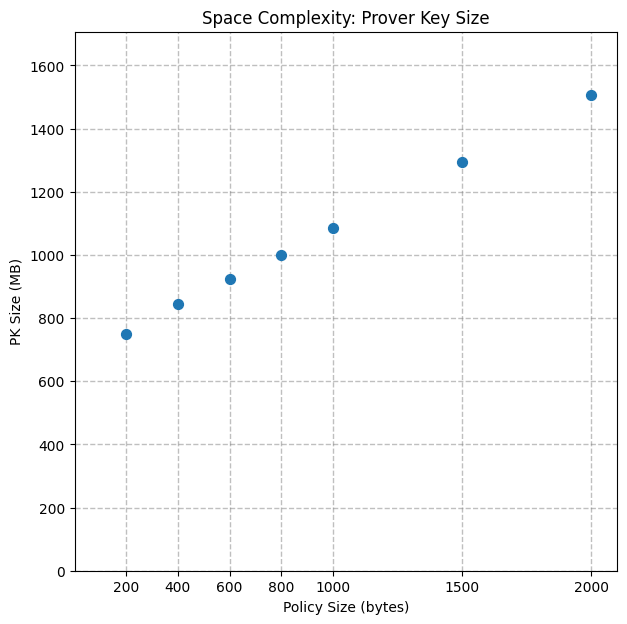

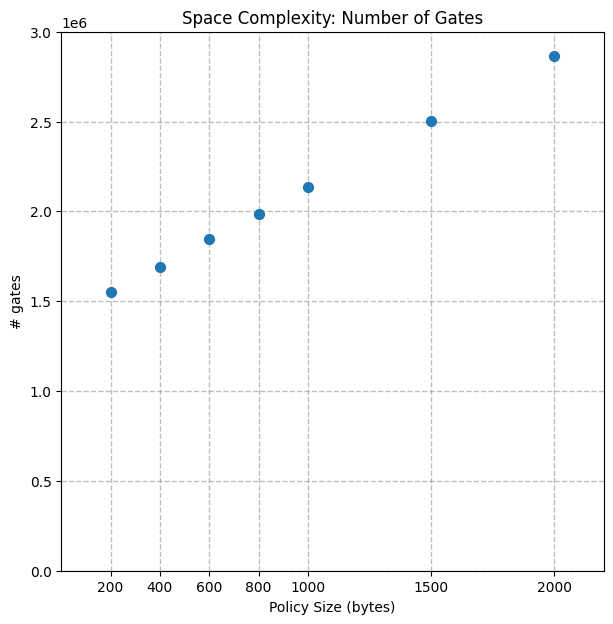

In [79]:
key_size = []
for i in url_range:
    key_size += [pandas.read_json("outputs/Test_HTTP_String/run7/output_libsnark_setup_HTTP_String_"+str(i)+"_7.json").round(5)[1].tail(2).values[0]/1000000]
#print("K:",key_size)
n_gates = []
for i in url_range:
    gates_frame = pandas.read_json("outputs/Test_HTTP_String/run7/output_java_HTTP_String_"+str(i)+"_7.json").round(5)
    gates_frame.columns = ['output', 'timestamp', 'cpu_timestamp']
    n_gates += [int(gates_frame['output'][gates_frame['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1])]
#print("G:",n_gates)

fig_pksize, ax_pksize = plt.subplots(figsize=(7, 7))



ax_pksize.scatter(url_range, key_size, s=50, zorder = 20)
ax_pksize.set_title("Space Complexity: Prover Key Size")
ax_pksize.set_xlabel("Policy Size (bytes)")
ax_pksize.set_ylabel("PK Size (MB)")
ax_pksize.grid(color='grey', alpha=0.5, linestyle='dashed', linewidth=1, zorder=1)
ax_pksize.set_xlim(0,max(url_range)+100)
ax_pksize.set_xticks(url_range)
ax_pksize.set_ylim(0,max(key_size)+200)



#formatter = ticker.ScalarFormatter(useMathText=True)
#formatter.set_scientific(True) 
#formatter.set_powerlimits((0,0)) 
fig_ngates, ax_ngates = plt.subplots(figsize=(7, 7))
ax_ngates.scatter(url_range, n_gates, s=50, zorder = 20)
ax_ngates.set_title("Space Complexity: Number of Gates")
ax_ngates.set_xlabel("Policy Size (bytes)")
ax_ngates.set_ylabel("# gates")
ax_ngates.grid(color='grey', alpha=0.5, linestyle='dashed', linewidth=1, zorder=1)
ax_ngates.set_xlim(0,max(url_range)+100)
print(math.ceil(int(max(n_gates))/1000000)*1000000)
ax_ngates.set_ylim(0,math.ceil(max(n_gates)/1000000)*1000000)
ax_ngates.set_xlim(0,2200)


ax_ngates.set_xticks(url_range)
#ax_ngates.set_yticks(range(0, 3000000, 300000))


#yScalarFormatter = ScalarFormatterClass(useMathText=True)
#yScalarFormatter.set_powerlimits((0,0))
#ax_ngates.yaxis.set_major_formatter(yScalarFormatter)
plt.show()

### Linear Regression

[[ 200]
 [ 400]
 [ 600]
 [ 800]
 [1000]
 [1500]
 [2000]]
733.3345798816569 1401271.4615384615


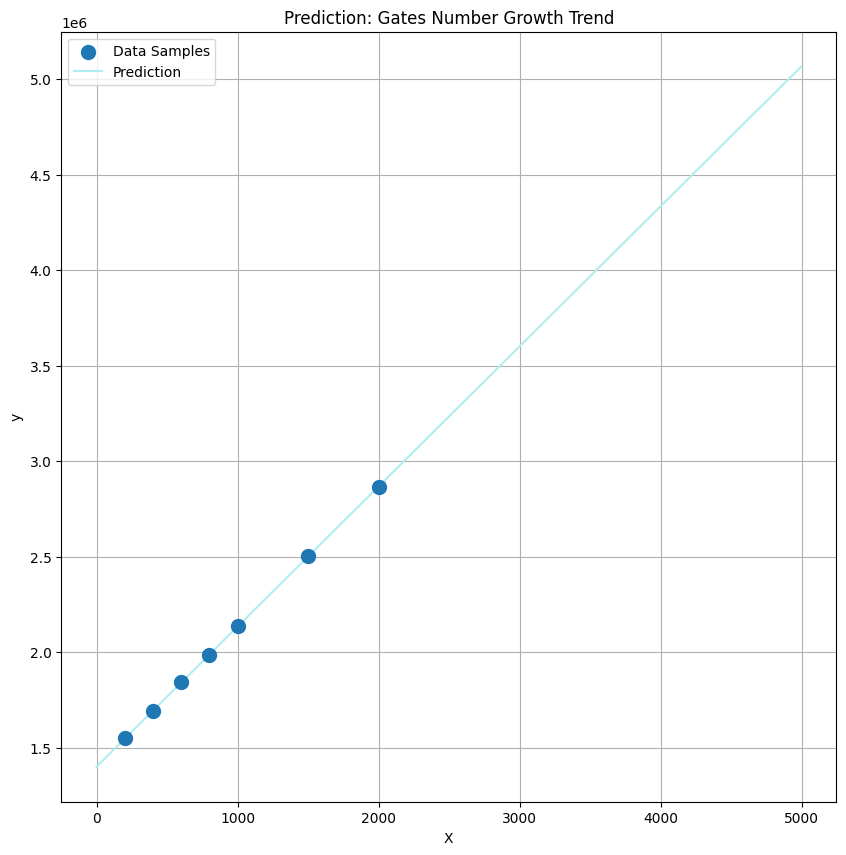

In [53]:
from sklearn.linear_model import LinearRegression
X = numpy.array(url_range).reshape(-1, 1)
print(X)
y = n_gates

model = LinearRegression()
model.fit(X, y)
print(model.coef_[0], model.intercept_)

url_range_pred = [i for i in range(0, 5000, 5)]
X_new = numpy.array(url_range_pred).reshape(-1, 1)
predictions = model.predict(X_new)

plt.figure(figsize=(10, 10))
plt.scatter(url_range, y, label='Data Samples', s=100, zorder=100)
plt.plot(url_range_pred, predictions, color='paleturquoise', label='Prediction')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Prediction: Gates Number Growth Trend')
plt.legend()
plt.grid(True)

plt.show()



In [71]:
def build_average(proc, circuit, path, url_range, run_range):
    times = pandas.DataFrame(url_range, columns = ['parameter'])
    for run in run_range:
        run=str(run)
        new_times = []
        #num_gates=[]
        for i in url_range:   
            df = pandas.read_json(path+"run"+run+"/output/output_"+proc+"_"+circuit+str(i)+"_"+run+".json").round(5)
            if proc == 'libsnark_setup':
                df = df[:-2]
            df.columns = ['output', 'timestamp']
            #num_gates += [df['output'][df['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1]]
            new_times += [df['timestamp'].tail(1).values[0]]
        times[run] = new_times
    #print(times.iloc[:,1:])
    times['avg'] = times.iloc[:,1:].mean(axis=1)
    return(times)

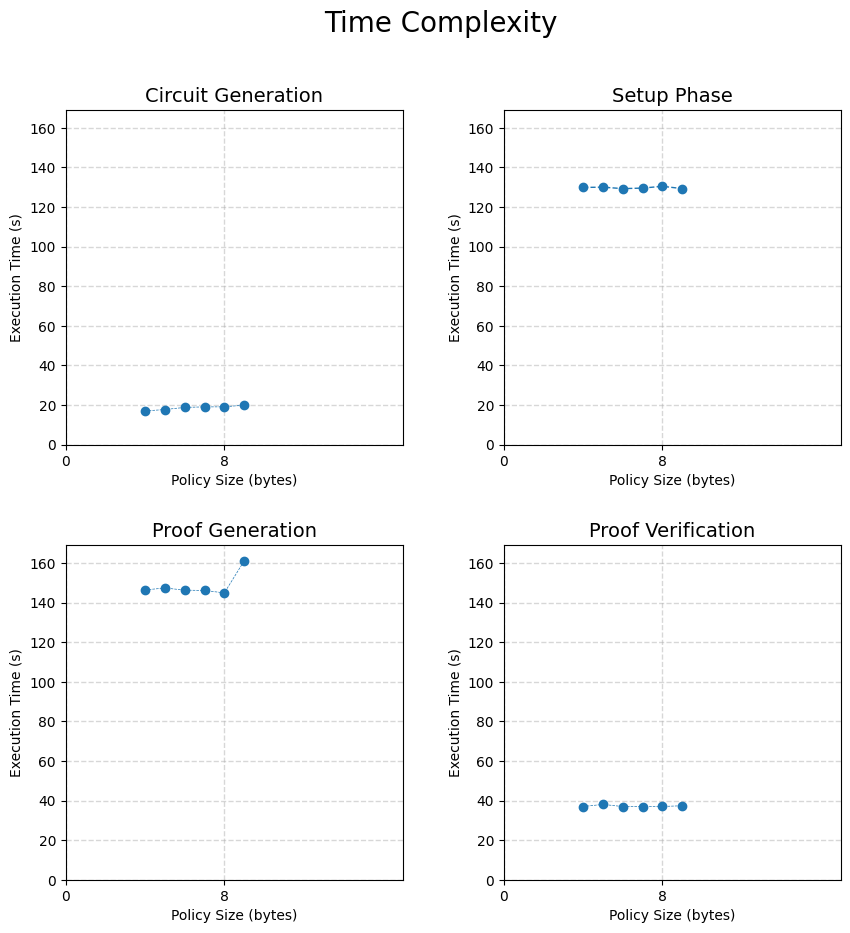

In [72]:
pk_size = []
circuit='Test_HTTP_Merkle'
url_range = [4, 5, 6, 7, 8, 9]
path = "outputs/Test_HTTP_Merkle/"
four_plots(circuit, path, url_range, range(1,3))

### HTTP_Merkle

[252.08464, 177.01201]


C:\Users\otti9\AppData\Local\Temp\ipykernel_14032\2317278776.py:101: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_times.show()


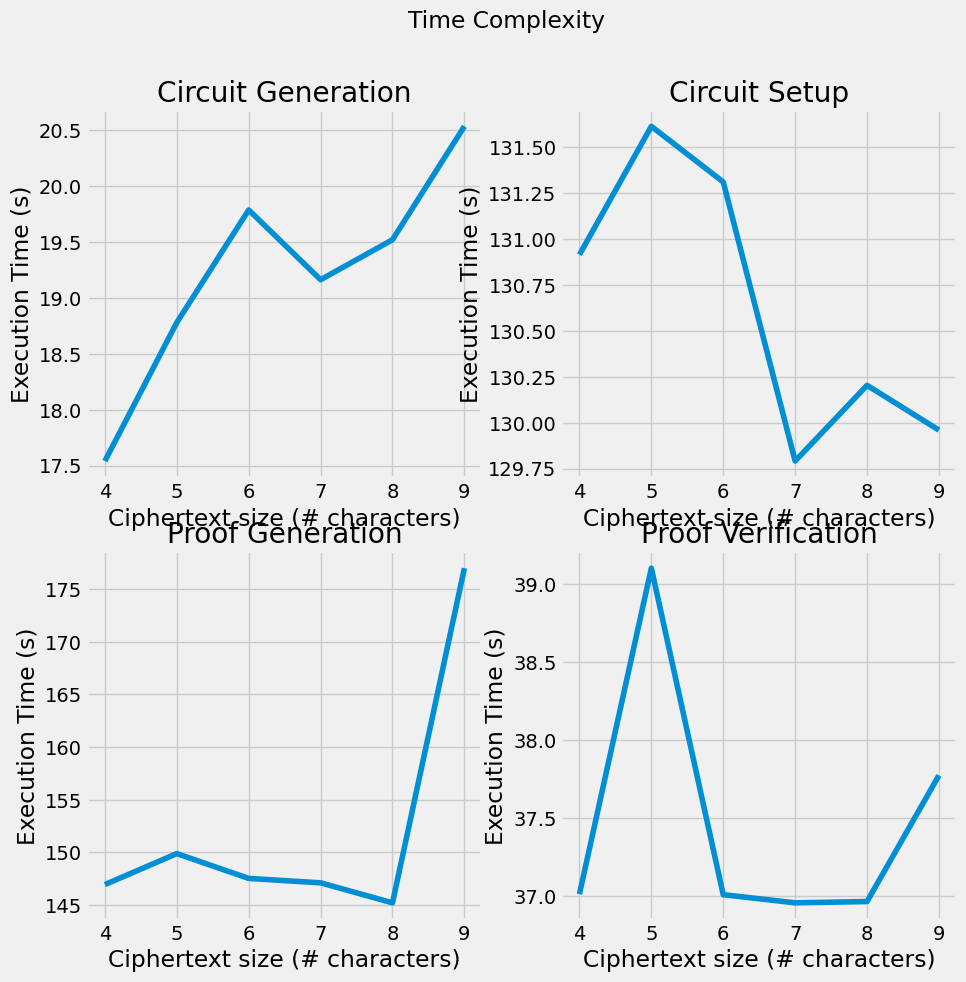

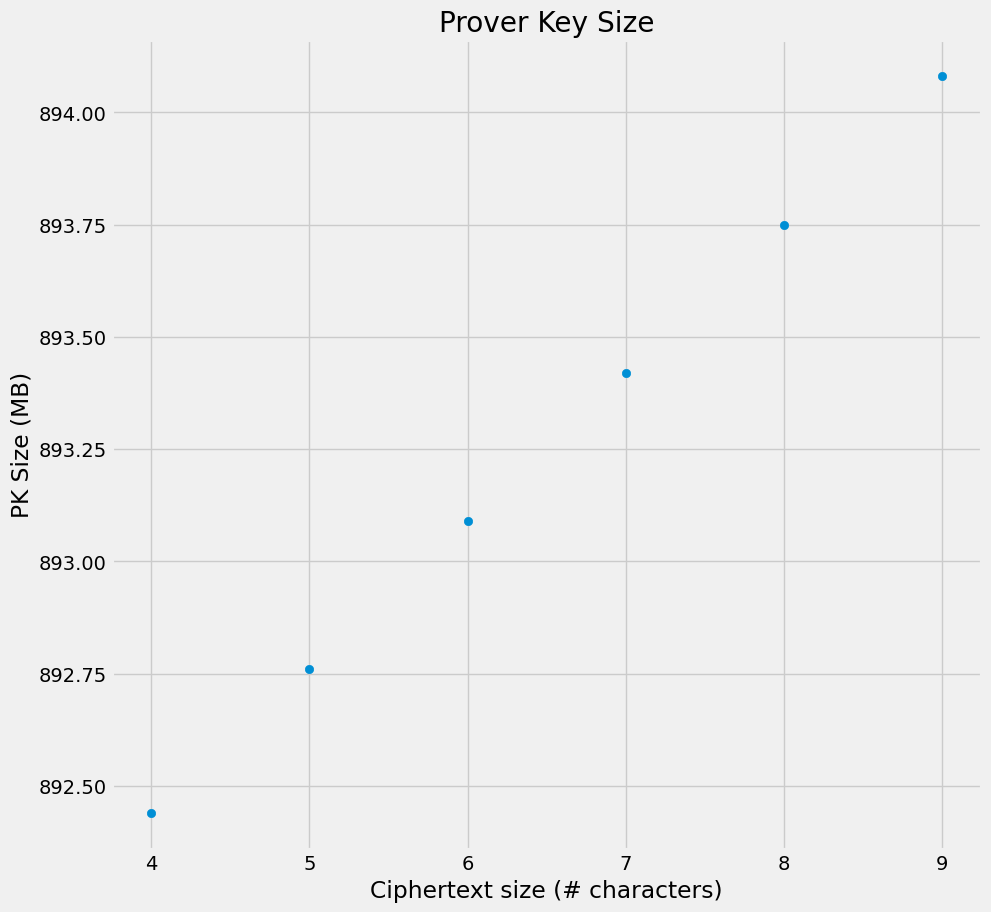

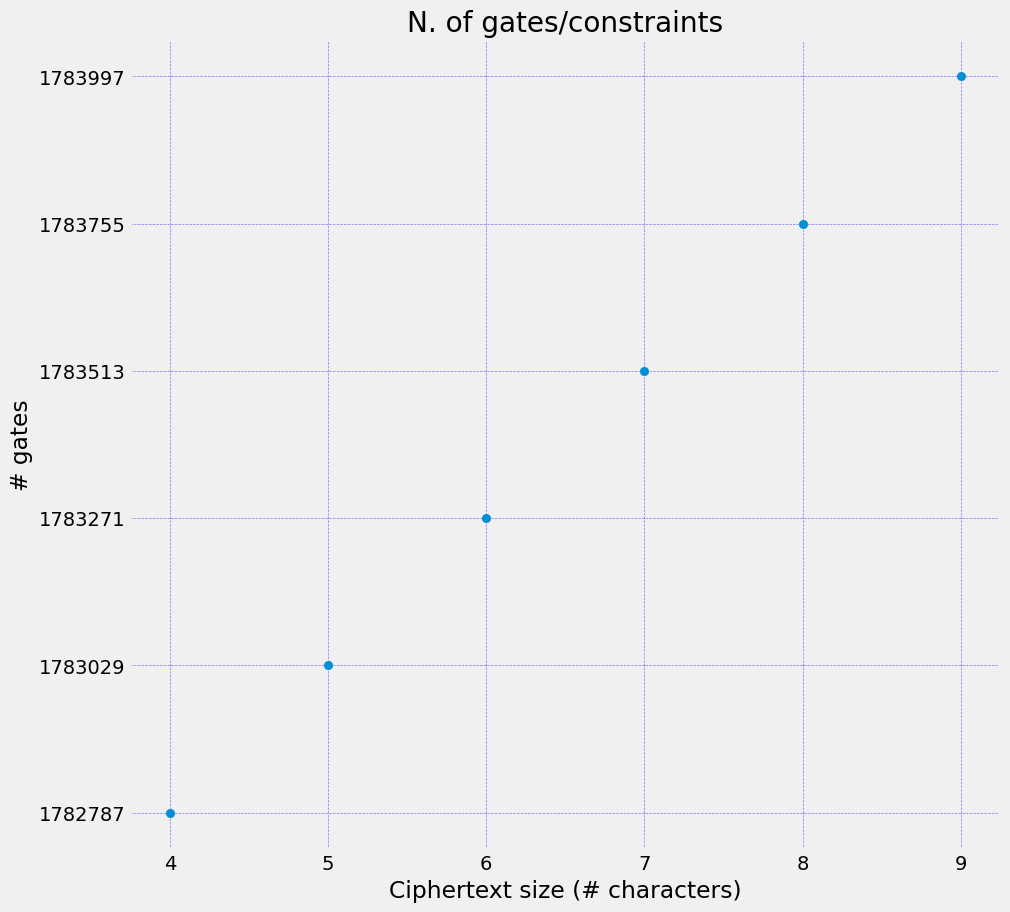

In [12]:
circuit='Test_HTTP_Merkle'
start=4
end=10
step = 1
fig_times, axs_time = plt.subplots(2, 2, figsize=(10, 10))

#fig_times = plt.figure()
ytitle_times = "Execution Time (s)"
xtitle = "Ciphertext size (# characters)"


df = pandas.read_json("outputs/"+circuit+"/run1/memory/memory_libsnark_prove_"+circuit+"4_1.json").round(5)
df.columns = ['memory', 'timestamp']
#max_memory += [max(df['memory'])]

num_gates=[]
times = pandas.DataFrame(columns = ['run', 'times'])
for i in range(start, end, step):
    df = pandas.read_json("outputs/"+circuit+"/run1/output/output_java_"+circuit+str(i)+"_1.json").round(5)
    df.columns = ['output', 'timestamp']
    num_gates += [df['output'].iloc[90].split()[-1]]
    times.loc[len(times)] = {'times': df['timestamp'].tail(1).values[0], 'run': i}
    #times = times.append({'times': df['timestamp'].tail(1).values[0], 'run': i}, ignore_index=True)

timestamps=df['timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')

axs_time[0][0].plot(times['run'], times['times'])
axs_time[0][0].set_title('Circuit Generation')
axs_time[0][0].set_xlabel(xtitle)
axs_time[0][0].set_ylabel(ytitle_times)

#plt.show()
fig_times.suptitle("Time Complexity")


pksizes = []
times = pandas.DataFrame(columns = ['run', 'times'])
for i in range(start, end, step):
    df = pandas.read_json("outputs/"+circuit+"/run1/output/output_libsnark_setup_"+circuit+str(i)+"_1.json").round(5)
    df.columns = ['output', 'timestamp']
    pksizes+=[round(df['timestamp'].tail(2).values[0]/1000000, 2)]
    
    df = df[:-2]
    #print(df)
    times.loc[len(times)] = {'times': df['timestamp'].tail(1).values[0], 'run': i}

pk_size += [pksizes[0]]
    
timestamps=df['timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')

axs_time[0][1].plot(times['run'], times['times'])
axs_time[0][1].set_title('Circuit Setup')
axs_time[0][1].set_xlabel(xtitle)
axs_time[0][1].set_ylabel(ytitle_times)



times = pandas.DataFrame(columns = ['run', 'times'])
for i in range(start, end, step):
    df = pandas.read_json("outputs/"+circuit+"/run1/output/output_libsnark_prove_"+circuit+str(i)+"_1.json").round(5)
    df.columns = ['output', 'timestamp']
    #print(df)
    times.loc[len(times)] = {'times': df['timestamp'].tail(1).values[0], 'run': i}
    #times = times.append({'times': df['timestamp'].tail(1).values[0], 'run': i}, ignore_index=True)
#print(times)
timestamps=df['timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')
exec_time += [timestamps.tail(1).values[0]]
print(exec_time)

axs_time[1][0].plot(times['run'], times['times'])
axs_time[1][0].set_title("Proof Generation")
axs_time[1][0].set_xlabel(xtitle)
axs_time[1][0].set_ylabel(ytitle_times)

times = pandas.DataFrame(columns = ['run', 'times'])
for i in range(start, end, step):
    df = pandas.read_json("outputs/"+circuit+"/run1/output/output_libsnark_verify_"+circuit+str(i)+"_1.json").round(5)
    df.columns = ['output', 'timestamp']
    #print(df)
    times.loc[len(times)] = {'times': df['timestamp'].tail(1).values[0], 'run': i}
    #times = times.append({'times': df['timestamp'].tail(1).values[0], 'run': i}, ignore_index=True)
#print(times)
timestamps=df['timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')


axs_time[1][1].plot(times['run'], times['times'])
axs_time[1][1].set_title('Proof Verification')
axs_time[1][1].set_xlabel(xtitle)
axs_time[1][1].set_ylabel(ytitle_times)

#fig_times.tight_layout(pad=1.0)

fig_times.show()

fig_pksize, ax_pksize = plt.subplots(figsize=(10, 10))
ax_pksize.scatter(times['run'], pksizes)
ax_pksize.set_title("Prover Key Size")
ax_pksize.set_xlabel(xtitle)
ax_pksize.set_ylabel("PK Size (MB)")


#formatter = ticker.ScalarFormatter(useMathText=True)
#formatter.set_scientific(True) 
#formatter.set_powerlimits((0,0)) 
fig_ngates, ax_ngates = plt.subplots(figsize=(10, 10))
ax_ngates.scatter(times['run'], num_gates)
ax_ngates.set_title("N. of gates/constraints")
ax_ngates.set_xlabel(xtitle)
ax_ngates.set_ylabel("# gates")
ax_ngates.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
#yScalarFormatter = ScalarFormatterClass(useMathText=True)
#yScalarFormatter.set_powerlimits((0,0))
#ax_ngates.yaxis.set_major_formatter(yScalarFormatter)
plt.show()


### Radar Chart: Comparison

#### Plotting subroutines

In [2]:
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import pandas as pd

class Radar(object):

    def __init__(self, fig, titles, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]

        self.n = len(titles)
        self.angles = np.arange(90, 90+360, 360.0/self.n)
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i, zorder=1) 
                         for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, fontsize=14)
        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label, alpha = 0.5)
            ax.spines["polar"].set_visible(False)
            ax.fill()
            ax.set_ylim(0, 6)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = (np.array(values) - np.array(minmax[0]))/((np.array(minmax[1])-np.array(minmax[0]))/5)
        print(values)
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        self.ax.fill(angle, values, alpha=0.25)


#### Actual Code

PK [842.992635, 893.075637, 900.0]
MEM [5636.24346, 6177.87392, 6200]
TIME [136.99474, 145.16287, 150]
[136.99474, 842.992635, 5636.24346]
[2.699474   0.64963175 0.6812173 ]
[3.516287   3.15378185 3.3893696 ]
[4.  3.5 3.5]


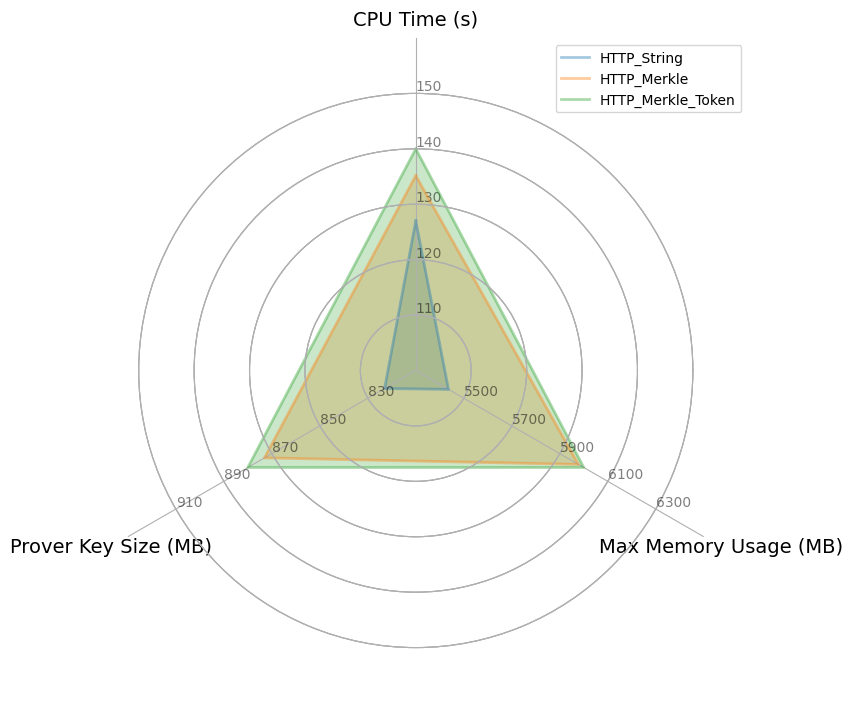

In [7]:
pk_size = []
pk_size += [pd.read_json("outputs/Test_HTTP_String/run5/output_libsnark_setup_HTTP_String_400_5.json").round(5)[1].tail(2).values[0]/1000000, 
            pd.read_json("outputs/Test_HTTP_Merkle/run2/output/output_libsnark_setup_Test_HTTP_Merkle6_2.json").round(5)[1].tail(2).values[0]/1000000, 
            #pandas.read_json("outputs/Test_HTTP_Merkle_Token/run1/output_libsnark_setup_Test_HTTP_String_6_2.json").round(5)[1].tail(2).values[0]]
            900000000/1000000]
max_mem = []
max_mem +=[max(pd.read_json("outputs/Test_HTTP_String/run5/memory_libsnark_prove_HTTP_String_400_5.json").round(5)[0]), 
           max(pd.read_json("outputs/Test_HTTP_Merkle/run2/memory/memory_libsnark_setup_Test_HTTP_Merkle6_2.json").round(5)[0]), 
           6200]
exec_time = []
exec_time += [pd.read_json("outputs/Test_HTTP_String/run5/output_libsnark_prove_HTTP_String_400_5.json").round(5)[1].tail(1).values[0], 
              pd.read_json("outputs/Test_HTTP_Merkle/run2/output/output_libsnark_prove_Test_HTTP_Merkle6_2.json").round(5)[1].tail(1).values[0], 
              150]
print("PK",pk_size)
print("MEM",max_mem)
print("TIME", exec_time)
#merkle_data = []
#merkle_token_data = []

fig = plt.figure(figsize=(7, 7))

titles = list(("CPU Time (s)", "Prover Key Size (MB)", "Max Memory Usage (MB)"))

labels = []



minmax = [[110, 830, 5500],[160, 930, 6500],[10, 20, 200]]
for i in range(3):
    labels += [[n for n in range(minmax[0][i], minmax[1][i], minmax[2][i])]]
#print(exec_time, pk_size, max_memory)
st = [exec_time[0], pk_size[0], max_mem[0]]
me = [exec_time[1], pk_size[1], max_mem[1]]
mt = [exec_time[2], pk_size[2], max_mem[2]]

print(st)
radar = Radar(fig, titles, labels)
radar.plot(st,"-", lw=2, alpha=0.4, label="HTTP_String", zorder = 100)
radar.plot(me,"-", lw=2, alpha=0.4, label="HTTP_Merkle", zorder = 100)
radar.plot(mt,"-", lw=2, alpha=0.4, label="HTTP_Merkle_Token", zorder = 100)

#radar.ax.spines['polar'].set_visible(False)

#radar.plot([3, 4, 3, 4, 2], "-", lw=2, color="g", alpha=0.4, label="third")
radar.ax.legend()